In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel       = False
parallel_nprc     = 48   # number of dask workers
parallel_nprc_bin = 20   # number of processor used to parallize the binning loop
parallel_tmem     = 200  # max. available RAM

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

 --> memory_limit: 4.167 GB


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43915 instead
  warnings.warn(


In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None # 5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'dmoc'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'dflux'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None # 
ref_name  = None #'TKE, ck=0.1' # None #
ref_year  = None #[1979,2019]
ref_mon, ref_day, ref_record = None, None, None
ref_cstr, ref_cnum = 'blue2red', 20
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995
ref_rescale = None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncol      = 2
which_dpi = 300
do_rescale= None #'log10'
proj      = 'pc'
do_contour= True
which_isopyc = 36.72
do_plot   = 'tcf'
do_reffig = True
figfac    = [8, 3.5] #[7, 3.5]

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl != None) and (which_cycl != "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
        
    if (ref_path != None) and (ref_path != "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)        
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None) and (ref_path != "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0 
else:
    do_reffig=False
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path != None) and (ref_path != "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names        

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


/albedo/home/pscholz/tripyview/tripyview/sub_mesh.py:139: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  mesh = pickle.load(fid)


### ATTENTION:
use here the density MOC levels that are specfic for your run. They might be different from the one im using here since they might need to be customized specific to your hydrography to be able to cover the whole density range in your simulation. So check the code you are using (see. gen_modules_diag.F90)

In [5]:
#______________________________________________________________________________________________________        
# define density levels 
# original dima
# std_dens=[0.0000,   30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
# 32.77778, 33.01000, 33.33333, 33.56000, 33.88889, 34.11000, 34.44444, 34.62000, 35.00000,
# 35.05000, 35.10622, 35.20319, 35.29239, 35.37498, 35.41300, 35.45187, 35.52380, 35.59136,
# 35.65506, 35.71531, 35.77247, 35.82685, 35.87869, 35.92823, 35.97566, 35.98000, 36.02115,
# 36.06487, 36.10692, 36.14746, 36.18656, 36.22434, 36.26089, 36.29626, 36.33056, 36.36383,
# 36.39613, 36.42753, 36.45806, 36.48778, 36.51674, 36.54495, 36.57246, 36.59500, 36.59932,
# 36.62555, 36.65117, 36.67621, 36.68000, 36.70071, 36.72467, 36.74813, 36.75200, 36.77111,
# 36.79363, 36.81570, 36.83733, 36.85857, 36.87500, 36.87940, 36.89985, 36.91993, 36.93965,
# 36.95904, 36.97808, 36.99682, 37.01524, 37.03336, 37.05119, 37.06874, 37.08602, 37.10303,
# 37.11979, 37.13630, 37.15257, 37.16861, 37.18441, 37.50000, 37.75000, 40.00000]

# my density layers 2nd try
std_dens=[ 0.00000, 29.50000, 30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
          32.77778, 33.01000, 33.33333, 33.56000, 33.78170, 33.79659, 33.81331, 33.83206, 33.85258, 33.87502,
          33.88889, 33.90019, 33.92843, 33.96012, 33.99567, 34.03267, 34.07050, 34.11295, 34.16058, 34.21400,
          34.27274, 34.33865, 34.41114, 34.47728, 34.55149, 34.62872, 34.71458, 34.81014, 34.91325, 35.02337,
          35.13865, 35.25518, 35.37026, 35.48624, 35.58763, 35.67886, 35.76112, 35.82097, 35.87630, 35.92691,
          35.97247, 36.02033, 36.06813, 36.11950, 36.17459, 36.23291, 36.29566, 36.36239, 36.43058, 36.50178,
          36.57474, 36.64730, 36.71590, 36.77414, 36.82096, 36.85908, 36.89139, 36.91962, 36.94532, 36.96900,
          36.98623, 37.00269, 37.01746, 37.03056, 37.04018, 37.05134, 37.06372, 37.07111, 37.10000, 37.25556,
          37.41111, 37.56667, 37.72222, 37.87778, 38.03333, 38.18889, 38.34444, 38.50000, 40.00000]

In [7]:
#___LOAD FESOM2 DATA___________________________________________________________________________________    
# load divergence of density class
dflux_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________    
    data = tpv.load_dmoc_data(mesh, datapath, descript, year, 'srf', std_dens, do_dflx=True, do_info=False,
                              do_load=False, do_persist=True)
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
    
    #___COMPUTE DIAPYCNAL VERTICAL VELOCITY____________________________________________________________
    # finds closest index of isopycnal class
    ts          = clock.time()
    ndens       = len(std_dens)
    idx_isopycn = np.argmin(np.abs(np.array(std_dens)-which_isopyc))
    print(' sigma_2 = {:5.2f} kg/m^3'.format(std_dens[idx_isopycn]))

    var        = list(data.keys())[0]
    dflux      = -data.isel(ndens=idx_isopycn).rename({var:'dflux'})
    del(data)
    dflux['dflux'] = dflux['dflux'].assign_attrs({
                    'description':'surface buoyancy forced transformations',
                    'long_name'  :'surface buoyancy forced transformations',
                    'short_name' :'surf. forc. transf.',
                    'units'      :'m/s',
                    'str_ldep'   :', $\\sigma_{{2}}$={:5.2f}kg/m^3'.format(std_dens[idx_isopycn])})
    dflux = dflux.load()
    if (ref_path != None) and (ref_path != "None"): 
        if ii == 0: 
            dflux_ref = dflux.copy()
            if do_reffig: dflux_list.append(dflux_ref) 
        else:        
            dflux_list.append( tpv.do_anomaly(dflux, dflux_ref) )
    else:                                                   
        dflux_list.append( dflux )
    del(dflux)    
    print(' --> elasped time to select data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> dflux uses {:3.2f} Gb:'.format(dflux_list[-1].nbytes/(1024**3)))
    print('')           

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load data: 0.07 min.
 --> data uses 0.08 Gb:

 sigma_2 = 36.72 kg/m^3
 --> elasped time to select data: 0.05 min.
 --> dflux uses 0.00 Gb:



In [8]:
dflux_list[0]

<xarray.Dataset>
Dimensions:  (elem: 244659)
Coordinates:
    lon      (elem) float32 59.63 -59.63 -179.2 59.8 ... 178.5 178.6 179.0 178.2
    lat      (elem) float32 -77.93 -77.77 -77.9 -77.8 ... -77.75 -77.94 -77.65
    w_A      (elem) float32 2.45e+08 3.288e+08 3.101e+08 ... 2.244e+08 3.409e+08
    dens     float32 36.72
    w_dens   float32 0.06342
Dimensions without coordinates: elem
Data variables:
    dflux    (elem) float32 -2.357e-07 -2.864e-07 ... -1.653e-07 -2.187e-07
Attributes: (12/19)
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       02f7d080
    FESOM_MeshPath:                      /albedo/work/user/pscholz/mesh_fesom...
    FESOM_mesh_representative_checksum:  297ddf9c482ca68c86a979e1bd5d3c97
    FESOM_ClimateDataPath:               /albedo/work/projects/p_fesom/FROM-O...
    ...                                  ...
    FESOM_include_fleapyear:             -1
    FESOM_use_floatice:                  0
    FESOM_whichEVP:                      0
    FESOM_evp_rheol_steps:               120
    FESOM_visc_option:                   5
    FESOM_w_split:                       0

In [9]:
# do regular binning of diapycnal velocities
Rearth     = 6371e3

dlon, dlat = 2.0, 2.0
lon_reg    = np.arange(-180, 180+dlon, dlon)
lat_reg    = np.arange( -90,  90+dlat, dlat)
mlon_reg , mlat_reg = (lon_reg[1:]+lon_reg[:-1])/2.0, (lat_reg[1:]+lat_reg[:-1])/2.0

#___________________________________________________________________________
# define function for longitudinal binning --> should be possible to parallelize
# this loop since each lon bin is independent
def binning_over_lon_lat(lon_i_ip1, lat_reg, dlon, dlat, data):
    #__________________________________________________________________________________________________________
    # select elements in longitudinal bin
    if   'nod2' in list(data.dims): dim_h = 'nod2'
    elif 'elem' in list(data.dims): dim_h = 'elem'
    data_lonbin = data.isel({dim_h:np.where(((data.lon-lon_i_ip1[0])*(data.lon-lon_i_ip1[1]) <= 0.))[0]}).copy()
    
    #__________________________________________________________________________________________________________
    mlat         = (lat_reg[1:]+lat_reg[:-1])/2.0
    coords       = {'lat':('nlat', mlat)}  
    dflux_latbin = xr.DataArray(np.zeros([mlat.size, ]), dims=['nlat',])

    #__________________________________________________________________________________________________________
    # do latitudinal binning
    rad = np.pi/180
    for yi in range(0,mlat.size):
        # select elements in latitudinal bin
        dvname              = list(data_lonbin.keys())[0]
        data_latbin         = data_lonbin.isel({dim_h:np.where(((data_lonbin.lat-lat_reg[yi])*(data_lonbin.lat-lat_reg[yi+1]) <= 0.))[0]})
        if data_latbin.dims[dim_h]==0: continue
        dx, dy              = np.pi*Rearth*dlon/180*np.cos((lat_reg[yi]+lat_reg[yi+1])/2.0*rad), np.pi*Rearth*dlat/180
        data_latbin[dvname] = data_latbin[dvname]*data_latbin['w_A']
        dflux_latbin[yi]    = data_latbin[dvname].sum(dim=dim_h)/dx/dy
    return(dflux_latbin)    

#_______________________________________________________________________________________________________________
bin_dflux_list=list()
for data in dflux_list:
    ts        = clock.time()
    dvname    = list(data.keys())[0]
    #___________________________________________________________________________________________________________
    # create xarray dataset
    varname   = 'bin_dflux'
    coords    = {'lon':(['nlon'], mlon_reg), 'lat':(['nlat' ], mlat_reg)}    
    data_vars = {varname:(['nlon', 'nlat'], np.zeros([mlon_reg.size, mlat_reg.size]), data[dvname].attrs)}
    bin_data  = xr.Dataset(data_vars=data_vars, coords=coords, attrs=data.attrs)

    #___________________________________________________________________________________________________________
    # loop over latitudinal bins
    # serial
    if not do_parallel:
        for xi in range(0, mlon_reg.size):
            bin_data[varname][xi,:] = binning_over_lon_lat([lon_reg[xi], lon_reg[xi+1]], lat_reg, dlon, dlat, data)[:]
    else:
        from joblib import Parallel, delayed
        results = Parallel(n_jobs=parallel_nprc_bin)(delayed(binning_over_lon_lat)([lon_reg[xi], lon_reg[xi+1]], lat_reg, dlon, dlat, data) for xi in range(0,mlon_reg.size))
        bin_data[varname][:,:] = xr.concat(results, dim='nlon')
        del(results)
    del(data)
    bin_data = bin_data.transpose('nlat','nlon')
    bin_dflux_list.append(bin_data)
    del(bin_data)
    #___________________________________________________________________________________________________________
    print(' --> elasped time to srf transformation: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> dflux uses {:3.2f} Gb:'.format(bin_dflux_list[-1].nbytes/(1024**3)))
    print('')        

 --> elasped time to srf transformation: 0.08 min.
 --> dflux uses 0.00 Gb:



--> histo: cmin, cmax =  -2.0112667929031357e-06 1.4367469153278816e-06
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -2e-06, 'cmax': 1.4e-06, 'cmap': <matplotlib.colors.ListedColormap object at 0x1461079ddb80>, 'clevel': array([-2.0e-06, -1.9e-06, -1.8e-06, -1.7e-06, -1.6e-06, -1.5e-06,
       -1.4e-06, -1.3e-06, -1.2e-06, -1.1e-06, -1.0e-06, -9.0e-07,
       -8.0e-07, -7.0e-07, -6.0e-07, -5.0e-07, -4.0e-07, -3.0e-07,
       -2.0e-07, -1.0e-07,  0.0e+00,  1.0e-07,  2.0e-07,  3.0e-07,
        4.0e-07,  5.0e-07,  6.0e-07,  7.0e-07,  8.0e-07,  9.0e-07,
        1.0e-06,  1.1e-06,  1.2e-06,  1.3e-06,  1.4e-06,  1.5e-06])}


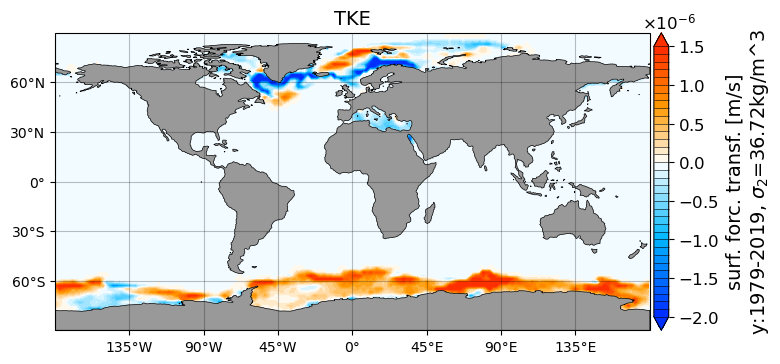

 --> elapsed time: 0.01884472370147705 min


In [10]:
ts = clock.time()
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = list(dflux_list[0].keys())[0] #vname
slabel = dflux_list[0][sname].attrs['str_lsave']
if spath != None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
ncol   = np.min([ncol,len(bin_dflux_list)])    
nrow   = np.ceil(len(bin_dflux_list)/ncol).astype('int')
if save_fname != None: spath = save_fname
pos_gap = [0.005, 0.04]
if   proj in ['nps, sps']:pos_gap = [0.005, 0.035] 
elif proj in ['rob']     :pos_gap = [0.005, -0.02] 
cinfo2 = cinfo.copy()
fig, ax, cbar = tpv.plot_hslice_reg(mesh, bin_dflux_list, input_names, box=box, n_rc=[nrow, ncol], 
                                    cinfo=cinfo2, do_rescale=do_rescale, 
                                    do_reffig=do_reffig, ref_cinfo=ref_cinfo, ref_rescale=ref_rescale,
                                    figsize=[ncol*figfac[0], nrow*figfac[1]], proj = proj, title='descript', 
                                    pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                                    do_save=spath, save_dpi=which_dpi)
print(' --> elapsed time: {} min'.format((clock.time()-ts)/60))            